In [0]:
import keras
import keras.backend as K
from keras.layers import Dense ,Conv2D ,Conv2DTranspose ,Dropout ,BatchNormalization ,Input ,MaxPooling2D ,concatenate
from keras.models import Model 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
import random
import os
from keras.optimizers import Adam
import random
from google.colab.patches import cv2_imshow
import keras.backend as K

Using TensorFlow backend.


In [0]:
def add_gaussian_noise(img):
    img  = cv2.resize(img , (224 ,224))
    mean = 0
    std = 0.15
    noisy_img = img + np.random.normal(mean, std, (224 ,224))*255
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    return noisy_img_clipped 
def add_swap_noise(img ,swap_rate = 0.4):
    img = cv2.resize(img ,(224 ,224))
    noise = np.zeros((224 ,224))
    x = [i for i in range(224*224)]
    num = int(swap_rate*len(x))
    choices = random.choices(x ,k = num)
    pixel_vals = [i for i in range(255)]
    for i in range(len(choices)):
        x = choices[i]//224
        y = choices[i]%224
        noise[x][y] = random.choice(pixel_vals)
    noisy_image = img + noise
    noisy_image = np.clip(noisy_image , 0 ,255)
    return noisy_image

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_dir = '/content/gdrive/My Drive/covidNet/BB_cropped_pn'

In [0]:
def plot_random_images(dir):
    images = os.listdir(dir)
    k = random.choice(images)
    if k.split('.') != 'csv':
        file_name = dir + '/' + k
        image = cv2.imread(file_name ,cv2.IMREAD_GRAYSCALE)
        swap_noised = add_swap_noise(image)
        guassian_noise = add_gaussian_noise(image)
        print('normal_image')
        cv2_imshow(cv2.resize(image ,(224 ,224)))
        print('swap_image')
        cv2_imshow(swap_noised)
        print('guassian_image')
        cv2_imshow(guassian_noise)

In [0]:
len(os.listdir(train_dir))

10233

normal_image


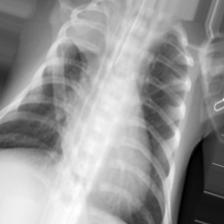

swap_image


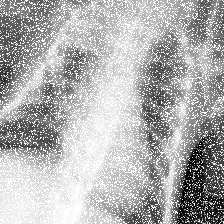

guassian_image


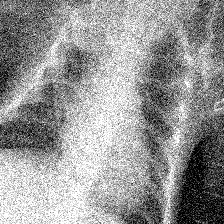

In [0]:
plot_random_images(train_dir)

In [0]:
def build_model(start_neurons):
    input_layer = Input((224 ,224 ,1))
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="tanh")(uconv1)
    model = Model(inputs = [input_layer] ,outputs = [output_layer])
    return model
model = build_model(32)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
def rmse(y_true,y_pred):
    return K.sum(K.square(y_true-y_pred))/(224*224)
model.compile(optimizer = Adam(lr = 0.000001) ,loss = 'mean_squared_error' ,metrics = [rmse])

In [0]:
def load_file(fname ,path ,classes = None ,fnames_list = None ):
    if fnames_list is not None:
        for i,list_ in enumerate(fnames_list):
            if fname in list_:
                k =  i
                break
    if classes is not None:
        image = cv2.imread(path + '/' +classes[i] + '/' + fname ,cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path + '/' + fname ,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image ,(224 ,224))
    guassian_noised = add_gaussian_noise(image).reshape((224 ,224 ,1))
    swap_noised = add_swap_noise(image).reshape((224 ,224 ,1))
    return (image.reshape((224 ,224 ,1)) ,guassian_noised ,swap_noised)
def data_generator(path ,batch_size_):
    fnames = os.listdir(path)
    if 'GTruth.csv' in fnames:
        fnames.remove('GTruth.csv')
    '''
    for i in range(len(classes)):
        fnames_list.append(os.listdir(path+'/'+classes[i]))
        fnames = fnames + os.listdir(path+'/'+classes[i])
        '''
    random.shuffle(fnames)
    print(len(fnames))
    no_of_batches = len(fnames)//batch_size_
    for i in range(no_of_batches):
        X_train = []
        Y_train = []
        print('training batch no {}'.format(i+1))
        try:
            present_files = fnames[i*batch_size_:(i+1)*batch_size_]
        except:
            present_files = fnames[i*batch_size_:]
        
        for name in present_files:
            tup = load_file(name ,path ,classes = None ,fnames_list = None )
            X_train.append(tup[1])
            X_train.append(tup[2])
            Y_train.append(tup[0])
            Y_train.append(tup[0])
        X_train = (np.asarray(X_train)/255.0 -0.5)*2
        Y_train = (np.asarray(Y_train)/255.0 -0.5)*2
        history = model.fit(X_train ,Y_train ,batch_size = 8 ,epochs = 5 ,verbose = 1, validation_split = 0.2 ,shuffle = True)
    return history

In [14]:
history = data_generator(train_dir ,batch_size_ = 300)

10233
training batch no 1
Train on 480 samples, validate on 120 samples
Epoch 1/5
480/480 [==============================] - 32s 67ms/step - loss: 0.2208 - rmse: 1.7666 - val_loss: 0.1993 - val_rmse: 1.5946
Epoch 2/5
480/480 [==============================] - 23s 47ms/step - loss: 0.2184 - rmse: 1.7471 - val_loss: 0.1969 - val_rmse: 1.5755
Epoch 3/5
480/480 [==============================] - 23s 48ms/step - loss: 0.2159 - rmse: 1.7276 - val_loss: 0.1945 - val_rmse: 1.5562
Epoch 4/5
480/480 [==============================] - 23s 48ms/step - loss: 0.2135 - rmse: 1.7076 - val_loss: 0.1920 - val_rmse: 1.5362
Epoch 5/5
480/480 [==============================] - 23s 48ms/step - loss: 0.2109 - rmse: 1.6870 - val_loss: 0.1895 - val_rmse: 1.5160
training batch no 2
Train on 480 samples, validate on 120 samples
Epoch 1/5
480/480 [==============================] - 23s 47ms/step - loss: 0.1979 - rmse: 1.5836 - val_loss: 0.1921 - val_rmse: 1.5367
Epoch 2/5
480/480 [==============================] -

In [0]:
def get_result(image ,plot = True):
    image = image.reshape((-1 ,224 ,224 ,1))
    image_ = ((image/255.0)-0.5)*2
    raw_result = model.predict(image_)
    result = raw_result.reshape((224 ,224))
    result = 255*((result/2)+0.5)
    if plot:
        cv2_imshow(image.reshape(224 ,224))
        cv2_imshow(result)
    return result

normal image :


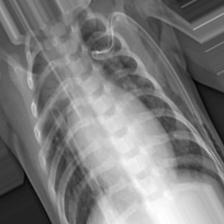

guassian_noised input:


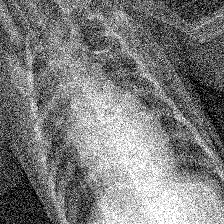

result :


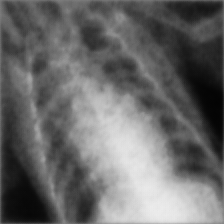

swap_noised imput :


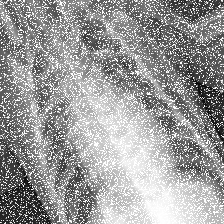

result:


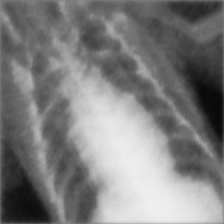

In [24]:
'''classes = os.listdir(validation_dir)
present_class = random.choice(classes)'''
#imgs = os.listdir(validation_dir + '/' +present_class)
imgs = os.listdir(train_dir)
img =  random.choice(imgs)
#img_dir = validation_dir + '/' + present_class + '/' +img
img_dir = train_dir + '/' +img
image = cv2.imread(img_dir ,cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image ,(224 ,224))
guassian_noised = add_gaussian_noise(image )
swap_noised = add_swap_noise(image)
result1 = get_result(guassian_noised ,plot = False)
result2 = get_result(swap_noised ,plot = False)
print('normal image :')
cv2_imshow(image)
print('guassian_noised input:')
cv2_imshow(guassian_noised)
print('result :')
cv2_imshow(result1)
print('swap_noised imput :')
cv2_imshow(swap_noised)
print('result:')
cv2_imshow(result2)

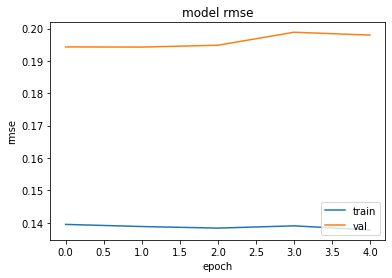

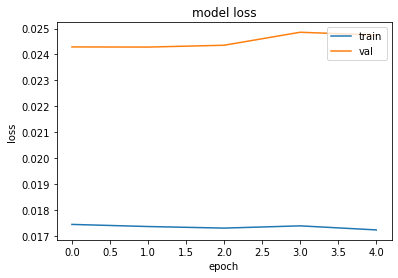

In [27]:
#learning curves
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
encoder = Model(inputs = model.input ,outputs = [model.get_layer('conv2d_12').output])

In [0]:
encoder.save('/content/gdrive/My Drive/encoder_results/denoising_autoencoder/denoise_encoderv4.h5')